<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/notebooks/03-MLP-Regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales MLP para regresión

✅ Conectar la notebook en modo GPU (**en este caso no es muy necesario**)

Entorno de ejecución → Cambiar tipo de entorno de ejecución

Algunas consideraciones:

* No dejar la notebook conectada sin actividad ya que Colab penaliza esto al asignar un entorno con GPU.
* No pedir el entorno con GPU si no se va a usar.

En esta notebook describiremos cómo resolver un problema de regresión usando una red neuronal MLP.

Usaremos el conjunto de datos [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construiremos un modelo para predecir la eficiencia en el uso de combustible (en MPG, millas por galón) de vehiculos hechos entre 1970 y 1980. La descripción de cada vehículo incluye atributos como: número de cilíndros, potencia, país de origen y peso.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-06-15 20:16:02.259924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## El conjunto de datos

El dataset original se puede encontrar en [UCI Machine Learning Repository](archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data).


In [2]:
#url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/03-Deep-Learning/data/auto-mpg.data"
#!wget --no-cache --backups=1 {url}

Leemo el conjunto de datos en un dataframe.

In [3]:
df = pd.read_csv('../data/auto-mpg.data',
                header=0,
                index_col=0,
                na_values = "?",
                comment='\t',
                skipinitialspace=True)
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
391,36.0,4,135.0,84.0,2370.0,13.0,82,1
392,27.0,4,151.0,90.0,2950.0,17.3,82,1
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2


### Limpieza de los datos

El dataset contiene algunos valores desconocidos.

In [4]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Eliminemos las filas con valores faltantes, ya que son pocas. También podríamos imputar valores.

In [5]:
# df[df.Horsepower.isna()]
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
391,36.0,4,135.0,84.0,2370.0,13.0,82,1
392,27.0,4,151.0,90.0,2950.0,17.3,82,1
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2


In [6]:
print(df.shape)
clean_df_drop = df.dropna(how='any')
print(clean_df_drop.shape)

from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df.Horsepower = imp.fit_transform(df.Horsepower.values.reshape(-1, 1))

#clean_df[clean_df.Horsepower.isna()]

clean_df = df
print(clean_df.shape)
clean_df.isna().sum()

(396, 8)
(390, 8)
(396, 8)


MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

La columna `"Origin"` es categorica, la codificamos con "one-hot" encoding

In [7]:
#df.shape: (396, 8)
df.shape

(396, 8)

In [8]:
oh_df = pd.get_dummies(data=clean_df,columns=['Origin'])
oh_df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,True,False,False
1,15.0,8,350.0,165.0,3693.0,11.5,70,True,False,False
2,18.0,8,318.0,150.0,3436.0,11.0,70,True,False,False
3,16.0,8,304.0,150.0,3433.0,12.0,70,True,False,False
4,17.0,8,302.0,140.0,3449.0,10.5,70,True,False,False
...,...,...,...,...,...,...,...,...,...,...
391,36.0,4,135.0,84.0,2370.0,13.0,82,True,False,False
392,27.0,4,151.0,90.0,2950.0,17.3,82,True,False,False
393,27.0,4,140.0,86.0,2790.0,15.6,82,True,False,False
394,44.0,4,97.0,52.0,2130.0,24.6,82,False,True,False


Reemplazamos los nombres del origen

In [9]:
oh_df.rename(columns={'Origin_1':'USA',
                      'Origin_2':'Europe',
                      'Origin_3':'Japan'},
             inplace=True)
oh_df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,True,False,False
1,15.0,8,350.0,165.0,3693.0,11.5,70,True,False,False
2,18.0,8,318.0,150.0,3436.0,11.0,70,True,False,False
3,16.0,8,304.0,150.0,3433.0,12.0,70,True,False,False
4,17.0,8,302.0,140.0,3449.0,10.5,70,True,False,False
...,...,...,...,...,...,...,...,...,...,...
391,36.0,4,135.0,84.0,2370.0,13.0,82,True,False,False
392,27.0,4,151.0,90.0,2950.0,17.3,82,True,False,False
393,27.0,4,140.0,86.0,2790.0,15.6,82,True,False,False
394,44.0,4,97.0,52.0,2130.0,24.6,82,False,True,False


Separamos las features y la variable dependiente.

In [10]:
X = oh_df.iloc[:,1:].values
y = oh_df['MPG'].values

print(X.shape, y.shape)

(396, 9) (396,)


### División en conjuntos de entrenamiento y prueba

Ahora dividimos el set de datos en un set de entrenamiento y otro de prueba.

Usaremos el conjunto de prueba en la evaluacion final de nuestro modelo.

In [11]:
from tensorflow.python import train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.85,random_state=189)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 336
Test size: 60


### Normalizamos

Inspeccionemos los rangos de las variables continuas

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

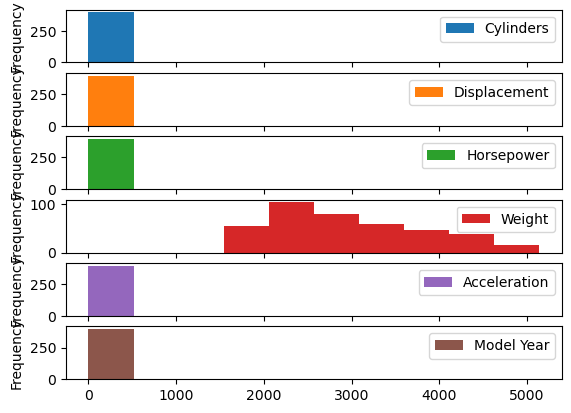

In [ ]:
oh_df.iloc[:,1:7].plot.hist(subplots=True, legend=True)

Es una buena práctica normalizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo *podría* converger sin normalización de features, esto suele dificultar el entrenamiento.

**Observaciones**:
1. Aunque sólo entrenamos el escalador con el conjunto de datos de entrenamiento, este escalador también se utilizará para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.
2. El reescalamiento debe aplicarse a cualquier otro dato que entre aal modelo, junto con la codificación de un punto que hicimos anteriormente. Eso incluye el conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.

In [13]:
X_train

array([[8, 351.0, 149.0, ..., True, False, False],
       [4, 134.0, 95.0, ..., False, False, True],
       [6, 231.0, 165.0, ..., True, False, False],
       ...,
       [4, 91.0, 53.0, ..., False, False, True],
       [4, 119.0, 92.0, ..., False, False, True],
       [8, 400.0, 175.0, ..., True, False, False]], dtype=object)

In [138]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

## El modelo

### Construcción del modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `sequential` con dos capas ocultas y una capa de salida que devuelve un único valor continuo.

Observa la elección de optimizador, métricas de rendimiento, función de costo y funciones de activación.

Podemos definir directamente el modelo, como en la notebook pasada:

In [15]:
model = keras.Sequential([
layers.Dense(64, activation='relu', input_shape=[X_train_scl.shape[1]]),
layers.Dense(64, activation='relu'),
layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])

2023-06-15 20:16:05.913274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Podemos también definirlo por medio de una función para generar nuevos modelos similares posteriormente:

In [38]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train_scl.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### ➖ A little detour...

Observemos que ya podríamos realizar predicciones con el modelo sin entrenar. Es decir, los pesos están inicializados

Tomamos un *batch* de 10 ejemplos de los datos de entrenamiento y realizamos las predicciones.

In [18]:
example_batch = X_train_scl[:10]
example_predictions = model.predict(example_batch)
example_predictions

1/1 [==============================] - 0s 72ms/step


array([[ 0.16128173],
       [-0.02470293],
       [-0.03855474],
       [ 0.02584147],
       [ 0.46797186],
       [ 0.24173222],
       [ 0.46564853],
       [ 0.5054219 ],
       [-0.06444037],
       [ 0.37599224]], dtype=float32)

Podríamos medir su error MSE, o cualquier otra métrica de rendimiento.

In [19]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train[:10],example_predictions)

357.5098370528619

### Entrenamos el modelo

Entrenamos el modelo durante 1000 épocas, registramos la precisión de entrenamiento y validación en el objeto `history`.

*El entrenamiendo debería durar alrededor de 1 minuto.*

In [20]:
X_train_scl

array([[ 1.50649086,  1.52542341,  1.16932108, ...,  0.78942283,
        -0.48038446, -0.49441323],
       [-0.85608057, -0.56642845, -0.24057442, ..., -1.26674826,
        -0.48038446,  2.02259959],
       [ 0.32520514,  0.36863897,  1.58706789, ...,  0.78942283,
        -0.48038446, -0.49441323],
       ...,
       [-0.85608057, -0.98094288, -1.3371598 , ..., -1.26674826,
        -0.48038446,  2.02259959],
       [-0.85608057, -0.71102651, -0.31890194, ..., -1.26674826,
        -0.48038446,  2.02259959],
       [ 1.50649086,  1.99777706,  1.84815965, ...,  0.78942283,
        -0.48038446, -0.49441323]])

In [21]:
X_train_prac = pd.DataFrame(X_train).replace(True, 1).replace(False, 0)

In [22]:
EPOCHS = 200

history = model.fit(
  X_train_prac, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

Epoch 1/200
9/9 [==============================] - 1s 18ms/step - loss: 32982.6250 - mae: 101.4041 - mse: 32982.6250 - val_loss: 319.5911 - val_mae: 14.7637 - val_mse: 319.5911
Epoch 2/200
9/9 [==============================] - 0s 3ms/step - loss: 247.0106 - mae: 13.0181 - mse: 247.0106 - val_loss: 321.6292 - val_mae: 14.9711 - val_mse: 321.6292
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 273.9231 - mae: 13.7184 - mse: 273.9231 - val_loss: 376.9337 - val_mae: 15.6220 - val_mse: 376.9337
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 1052.1547 - mae: 26.6015 - mse: 1052.1547 - val_loss: 3256.6292 - val_mae: 56.7547 - val_mse: 3256.6292
Epoch 5/200
9/9 [==============================] - 0s 3ms/step - loss: 1853.3339 - mae: 36.9050 - mse: 1853.3339 - val_loss: 406.9442 - val_mae: 15.8946 - val_mse: 406.9442
Epoch 6/200
9/9 [==============================] - 0s 3ms/step - loss: 1543.4575 - mae: 33.1375 - mse: 1543.4575 - val_loss: 5028.338

9/9 [==============================] - 0s 3ms/step - loss: 1329.7675 - mae: 33.3624 - mse: 1329.7675 - val_loss: 549.6196 - val_mae: 22.6676 - val_mse: 549.6196
Epoch 49/200
9/9 [==============================] - 0s 3ms/step - loss: 241.5269 - mae: 12.4446 - mse: 241.5269 - val_loss: 1349.2754 - val_mae: 33.5945 - val_mse: 1349.2754
Epoch 50/200
9/9 [==============================] - 0s 3ms/step - loss: 1261.5718 - mae: 26.7074 - mse: 1261.5718 - val_loss: 61.0959 - val_mae: 5.8171 - val_mse: 61.0959
Epoch 51/200
9/9 [==============================] - 0s 3ms/step - loss: 1114.4849 - mae: 23.1958 - mse: 1114.4849 - val_loss: 1536.2789 - val_mae: 38.2825 - val_mse: 1536.2789
Epoch 52/200
9/9 [==============================] - 0s 3ms/step - loss: 310.9637 - mae: 13.6453 - mse: 310.9637 - val_loss: 108.1401 - val_mae: 8.0990 - val_mse: 108.1401
Epoch 53/200
9/9 [==============================] - 0s 3ms/step - loss: 1281.7758 - mae: 27.4881 - mse: 1281.7758 - val_loss: 1000.0875 - val_mae: 

9/9 [==============================] - 0s 3ms/step - loss: 718.3477 - mae: 24.3738 - mse: 718.3477 - val_loss: 1590.0031 - val_mae: 38.9492 - val_mse: 1590.0031
Epoch 96/200
9/9 [==============================] - 0s 3ms/step - loss: 503.9675 - mae: 19.8831 - mse: 503.9675 - val_loss: 459.7188 - val_mae: 18.7419 - val_mse: 459.7188
Epoch 97/200
9/9 [==============================] - 0s 3ms/step - loss: 741.6429 - mae: 25.0734 - mse: 741.6429 - val_loss: 826.1069 - val_mae: 28.0309 - val_mse: 826.1069
Epoch 98/200
9/9 [==============================] - 0s 3ms/step - loss: 401.7166 - mae: 17.9467 - mse: 401.7166 - val_loss: 1213.3657 - val_mae: 31.9722 - val_mse: 1213.3657
Epoch 99/200
9/9 [==============================] - 0s 4ms/step - loss: 729.3910 - mae: 24.5193 - mse: 729.3910 - val_loss: 92.9312 - val_mae: 8.4445 - val_mse: 92.9312
Epoch 100/200
9/9 [==============================] - 0s 4ms/step - loss: 62.6693 - mae: 6.3140 - mse: 62.6693 - val_loss: 582.9868 - val_mae: 23.3308 - 

Epoch 143/200
9/9 [==============================] - 0s 4ms/step - loss: 461.3291 - mae: 17.2222 - mse: 461.3291 - val_loss: 65.1037 - val_mae: 6.4442 - val_mse: 65.1037
Epoch 144/200
9/9 [==============================] - 0s 3ms/step - loss: 470.0353 - mae: 17.4878 - mse: 470.0353 - val_loss: 38.4067 - val_mae: 4.8553 - val_mse: 38.4067
Epoch 145/200
9/9 [==============================] - 0s 3ms/step - loss: 260.0920 - mae: 12.2867 - mse: 260.0920 - val_loss: 664.1343 - val_mae: 23.5934 - val_mse: 664.1343
Epoch 146/200
9/9 [==============================] - 0s 4ms/step - loss: 477.5815 - mae: 19.7505 - mse: 477.5815 - val_loss: 230.3036 - val_mae: 14.4378 - val_mse: 230.3036
Epoch 147/200
9/9 [==============================] - 0s 4ms/step - loss: 168.9536 - mae: 11.4251 - mse: 168.9536 - val_loss: 189.6575 - val_mae: 11.6656 - val_mse: 189.6575
Epoch 148/200
9/9 [==============================] - 0s 3ms/step - loss: 533.4480 - mae: 20.8428 - mse: 533.4480 - val_loss: 436.6873 - val_m

Epoch 191/200
9/9 [==============================] - 0s 4ms/step - loss: 348.1954 - mae: 16.6951 - mse: 348.1954 - val_loss: 164.8666 - val_mae: 12.1261 - val_mse: 164.8666
Epoch 192/200
9/9 [==============================] - 0s 3ms/step - loss: 214.8055 - mae: 13.0031 - mse: 214.8055 - val_loss: 219.0673 - val_mae: 12.9645 - val_mse: 219.0673
Epoch 193/200
9/9 [==============================] - 0s 4ms/step - loss: 310.9964 - mae: 16.1767 - mse: 310.9964 - val_loss: 238.7233 - val_mae: 14.8692 - val_mse: 238.7233
Epoch 194/200
9/9 [==============================] - 0s 3ms/step - loss: 176.7104 - mae: 12.0639 - mse: 176.7104 - val_loss: 273.1088 - val_mae: 14.6557 - val_mse: 273.1088
Epoch 195/200
9/9 [==============================] - 0s 3ms/step - loss: 360.7165 - mae: 16.2731 - mse: 360.7165 - val_loss: 133.5091 - val_mae: 10.7889 - val_mse: 133.5091
Epoch 196/200
9/9 [==============================] - 0s 3ms/step - loss: 228.7864 - mae: 13.5738 - mse: 228.7864 - val_loss: 270.3100 -

Podríamos visualizar la historia del entrenamiento durante cada época en un dataframe usando las estadísticas almacenadas en el diccionario `history.history`.

Realizaremos algunas manipulaciones adicionales con las historia del entrenamiento.

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,228.786438,13.573795,228.786438,270.310028,14.729947,270.310028,195
196,184.162949,11.914854,184.162949,100.391876,9.040339,100.391876,196
197,330.398224,16.344553,330.398224,263.472809,14.595678,263.472809,197
198,173.226639,11.673950,173.226639,131.297729,10.704225,131.297729,198
199,365.347717,16.834818,365.347717,97.343277,8.264176,97.343277,199


Definimos la siguiente función para graficar las métricas de rendimiento durante el entrenamiento.

In [24]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(history.epoch, history.history['mae'],
            label='Train Error')
    plt.plot(history.epoch, history.history['val_mae'],
            label = 'Val Error')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(history.epoch, history.history['mse'],
            label='Train Error')
    plt.plot(history.epoch, history.history['val_mse'],
            label = 'Val Error')
    plt.legend()
    plt.show()

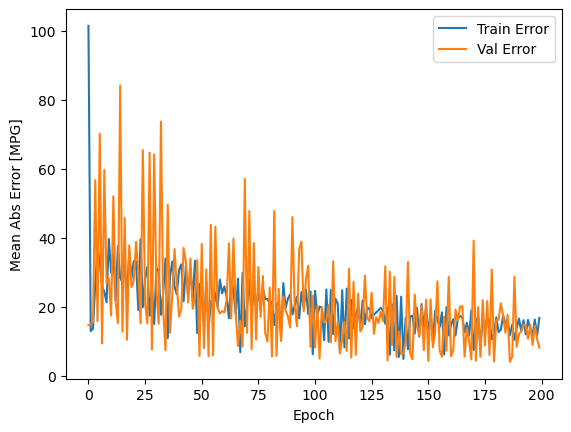

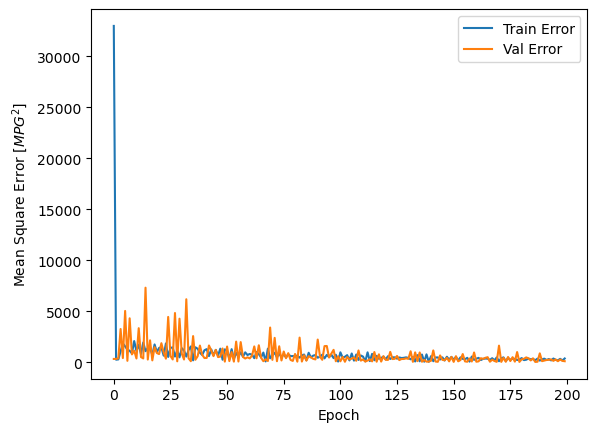

In [25]:
plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. **Esta es una señal de overfitting**.

Repitamos el entrenamiento con menos épocas.

Observa el parámetro `verbose`

In [101]:
def build_model():
    model = keras.Sequential([
    layers.Dense(80, activation='sigmoid', input_shape=[X_train_scl.shape[1]]),
    layers.Dense(80, activation='sigmoid'),
    layers.Dense(80, activation='sigmoid'),
    layers.Dense(1)
    ])
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    #optimizer = keras.optimizers.Adam(learning_rate=0.001)
    optimizer = keras.optimizers.experimental.SGD(learning_rate=0.01)
    
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 80)                800       
                                                                 
 dense_151 (Dense)           (None, 80)                6480      
                                                                 
 dense_152 (Dense)           (None, 80)                6480      
                                                                 
 dense_153 (Dense)           (None, 1)                 81        
                                                                 
Total params: 13,841
Trainable params: 13,841
Non-trainable params: 0
_________________________________________________________________
2/2 - 0s - loss: 5.8949 - mae: 1.6444 - mse: 5.8949 - 17ms/epoch - 9ms/step
MAE para las predicciones en el conjunto de prueba: 1.6444 MPG


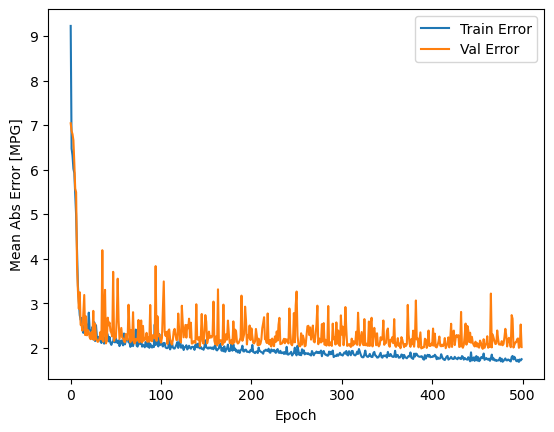

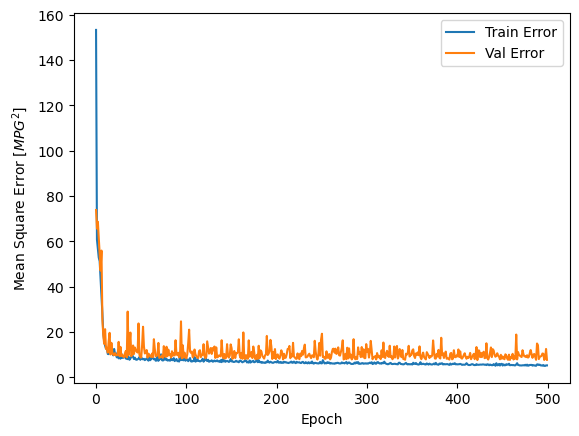

In [107]:
model_me = build_model()

EPOCHS = 500

#history = model_me.fit(X_train_scl, y_train, epochs=EPOCHS,
#                    validation_split = 0.2, verbose=0)

model_me.summary()

history = model_me.fit(X_train_scl, y_train, epochs=EPOCHS,
                    validation_split = 0.2, verbose=False)

loss, mae, mse = model_me.evaluate(X_test_scl, y_test, verbose=2)
print(f"MAE para las predicciones en el conjunto de prueba: {np.round(mae,4)} MPG")

plot_history(history)

In [140]:
valor1

array([[4.000e+00],
       [1.200e+02],
       [7.900e+01],
       [2.625e+03],
       [1.860e+01],
       [8.200e+01],
       [1.000e+00],
       [0.000e+00],
       [0.000e+00]])

In [155]:
test = pd.read_csv('../data/mpg_new_data.csv')
# 28 y 31
test.drop('Unnamed: 0', axis=1, inplace=True)
test['Origin_2']=0
test['Origin_3']=0
display(test)
#print(type(model_me))
valor1=test.iloc[0]
print(valor1)
#valor1=scaler.transform(valor1)
print(valor1)
model_me.predict(valor1.values.reshape(-1,1))

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Origin_2,Origin_3
0,4,120,79,2625,18.6,82,1,0,0
1,4,119,82,2720,19.4,82,1,0,0


Cylinders          4.0
Displacement     120.0
Horsepower        79.0
Weight          2625.0
Acceleration      18.6
Model Year        82.0
Origin             1.0
Origin_2           0.0
Origin_3           0.0
Name: 0, dtype: float64
Cylinders          4.0
Displacement     120.0
Horsepower        79.0
Weight          2625.0
Acceleration      18.6
Model Year        82.0
Origin             1.0
Origin_2           0.0
Origin_3           0.0
Name: 0, dtype: float64


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_36/dense_150/BiasAdd' defined at (most recent call last):
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_11568/3732173780.py", line 6, in <module>
      model_me.predict(test.iloc[0,:])
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
      return self(x, training=False)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/keras/layers/core/dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'sequential_36/dense_150/BiasAdd'
Matrix size-incompatible: In[0]: [9,1], In[1]: [9,80]
	 [[{{node sequential_36/dense_150/BiasAdd}}]] [Op:__inference_predict_function_2475590]

### Métricas de rendimiento

Veamos qué tan bien generaliza el modelo al usar el **conjunto de prueba**, el cual no fue usado para entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

### Predicciones

Finalmente, predecimos los valores de MPG utilizando los datos del conjunto de prueba

2/2 [==============================] - 0s 2ms/step


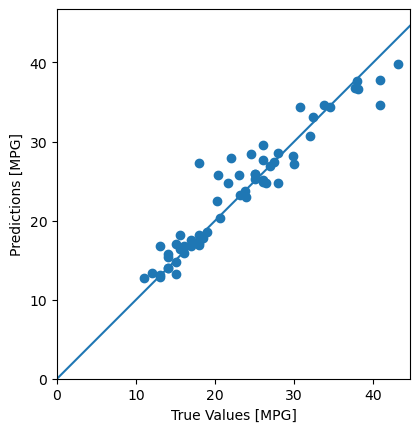

In [108]:
y_pred = model_me.predict(X_test_scl).flatten()

plt.scatter(y_test, y_pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Veamos la distribución de errores.

(60,)


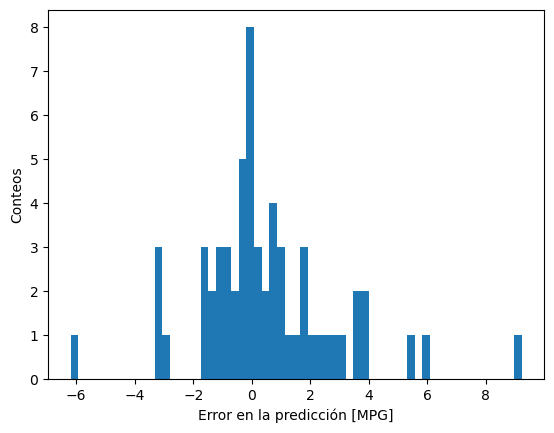

In [109]:
error = y_pred - y_test
#plt.hist(error, bins = 25)
print(error.shape)
plt.hist(error, bins = 59 )
plt.xlabel("Error en la predicción [MPG]")
plt.ylabel("Conteos")
plt.show()

## ⭕ Práctica

1. Repite el experimento usando 100 épocas y sin normalizar los datos, ¿qué le sucede a las métricas de rendimiento?

**El objetivo de los siguientes puntos es experimentar para subir las métricas de rendimiento del modelo.**

2. Usando los datos normalizados, cambia los parámetros del módelo:
    * Número de capas ocultas
    * Número de nueronas en las capas ocultas
    * Funciones de activación de las capas ocultas
    * Optimizador

Puedes hacer el modelo más sencillo o más complejo.

3. ¿Mejora el rendimiento de tu modelo si imputas los 6 valores faltantes?

En cada uno de los 3 puntos anteriores, grafica también un `scatterplot` de los valores reales contra los valores predichos.

Ya que tengas tu mejor modelo, toma el archivo `mpg_new_data.csv` del repositorio y obten las predicciones para estos datos. Al final de la práctica las podrás comparar contra los valores reales.

## Conclusiones

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión. Otra métrica de regresión común es el error absoluto medio (MAE).
* Cuando las features de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, es preferible usar una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* El entrenamiento con pocas épocas es una técnica útil para evitar el sobreajuste. Otra técnica es el *early stopping** (coming soon...).